In [1]:
def read_data(filename):
    with open(filename, 'rt', encoding="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

In [2]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

150000
3
50000
3


In [3]:
import konlpy

konlpy.__version__

'0.5.1'

In [4]:
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'지금은 캡스톤 프로젝트 4조 발표다.'))

[('지금', 'Noun'), ('은', 'Josa'), ('캡', 'Noun'), ('스톤', 'Noun'), ('프로젝트', 'Noun'), ('4조', 'Number'), ('발표', 'Noun'), ('다', 'Josa'), ('.', 'Punctuation')]


In [5]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json', 'rt', encoding="utf-8") as f:
        train_docs = json.load(f)
    with open('test_docs.json', 'rt', encoding="utf-8") as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [6]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [7]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [8]:
# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


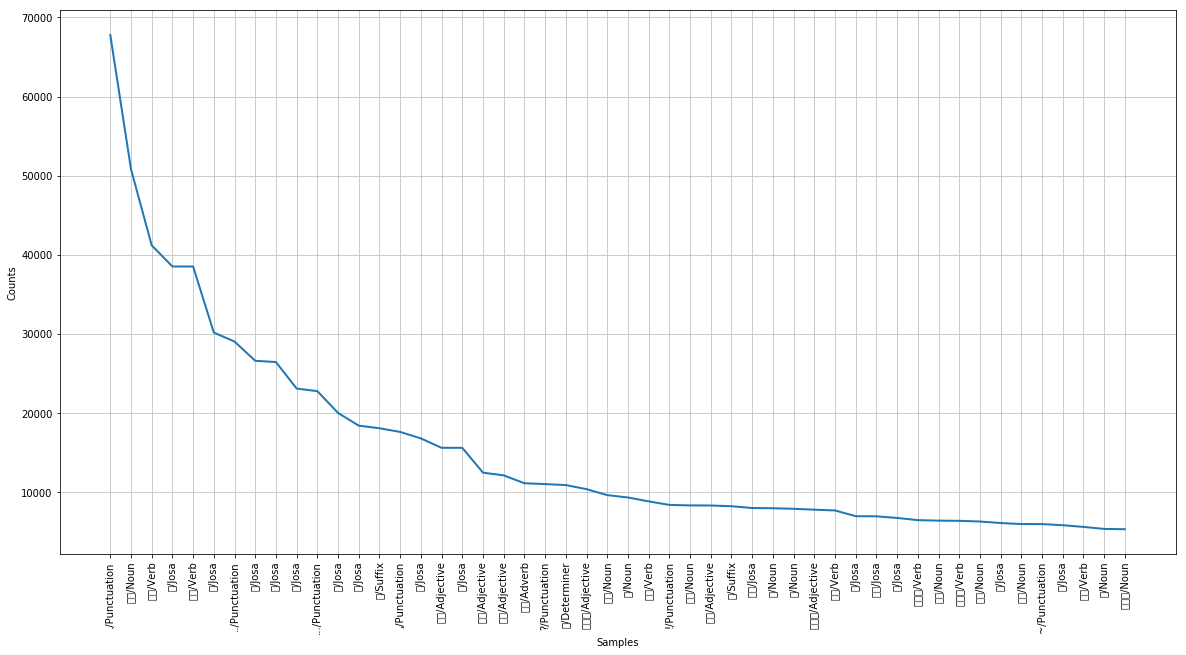

In [9]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [10]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [11]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150000/150000 [==============================] - 36s 238us/sample - loss: 0.3878 - binary_accuracy: 0.8354
Epoch 2/10
150000/150000 [==============================] - 19s 128us/sample - loss: 0.3160 - binary_accuracy: 0.8652
Epoch 3/10
150000/150000 [==============================] - 18s 118us/sample - loss: 0.2908 - binary_accuracy: 0.8789 - loss: 0.2881 - 
Epoch 4/10
150000/150000 [==============================] - 18s 120us/sample - loss: 0.2705 - binary_accuracy: 0.8897
Epoch 5/10
150000/150000 [==============================] - 18s 118us/sample - loss: 0.2512 - binary_accuracy: 0.8994
Epoch 6/10
150000/150000 [==============================] - 18s 120us/sample - loss: 0.2309 - binary_accuracy: 0.9093 - loss: 0.2 - ETA: 0s - loss: 0.2308 - binary_accuracy
Epoch 7/10
150000/150000 [==============================] - 17s 113us/sample - loss: 0.2108 - binar

In [13]:
results

[0.41806711189031603, 0.8508]

In [19]:
def predict(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정적인 문장\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정적인 문장\n".format(review, (1 - score) * 100))

In [21]:
predict("국민 노후자금을 앞세워 경영권을 박탈한 연금사회주의")

[국민 노후자금을 앞세워 경영권을 박탈한 연금사회주의]는 69.16% 확률로 부정적인 문장



In [51]:
model.save("article_first")

AttributeError: 'Sequential' object has no attribute 'load'